# Buyer-Intent Optimal Questionnaire For Modeling Part and Performance Results
### The folwoing picture shows the methodology that I used to find the optimal one
---
![title](img/optimal_labeling_selection.jpg)

In [45]:
import ml_sagemaker_helper as sm_helper
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

## Clean up locations for Sagemaker
#### This is needed to make sure the folders related to train and test data are clean for model training for each 3 labels

In [2]:
#Clean up the prevoius location used by last automl to upload fresh train and test files
sm_helper.s3_clean_up(bucket = sm_helper.bucket, prefix = sm_helper.param_dict['dev']['train_prefix'])
sm_helper.s3_clean_up(bucket = sm_helper.bucket, prefix=sm_helper.param_dict['dev']['test_prefix'])
sm_helper.s3_clean_up(bucket = sm_helper.bucket, prefix=sm_helper.param_dict['dev']['inference_prefix'])

True

## Make 3 different train/validate and test sets for each questionaire

In [3]:
sm_helper.make_and_clean_up_buyer_intent_data_set('csvs/buyer_intent_tr_val_set.csv', 'csvs/buyer_intent_tr_val_set_q1.csv', 
                                              'csvs/buyer_intent_tr_val_set_q2.csv', 'csvs/buyer_intent_tr_val_set_q3.csv')

True

In [4]:
sm_helper.make_and_clean_up_buyer_intent_data_set('csvs/buyer_intent_test_set.csv', 'csvs/buyer_intent_test_set_q1.csv', 
                                              'csvs/buyer_intent_test_set_q2.csv', 'csvs/buyer_intent_test_set_q3.csv')

True

## STAGE_LABEL_1
#### STEP 1 : Find Optimal model for first label
#### STEP 2 : Load test data on s3 for inferencing
#### STEP 3 : Find and Run Optimal model to get Inferenced predicted data and load to s3
#### STEP 4 : Compute precision/recall for labels labels = ["Dreamer", "Casual Explorer", "Active Searcher", "Ready to Transact"]
----

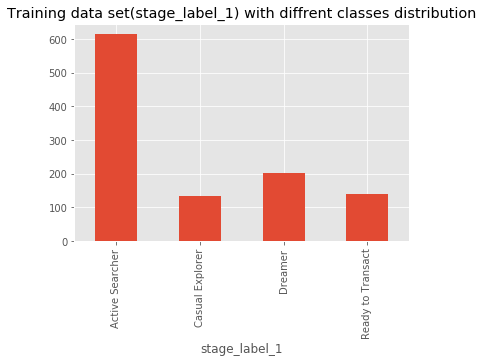

In [54]:
# Training data set user segment distribution : enough data on each class
df_q1_label_dist = pd.read_csv('csvs/buyer_intent_test_set_q1.csv')
df_q1_label_dist = df_q1_label_dist.groupby(['stage_label_1']).size()
df_q1_label_dist.plot.bar(title = 'Training data set(stage_label_1) with diffrent classes distribution')

In [5]:
(best_candidate_1, best_candidate_name_1, best_candidate_performance_1 ) = sm_helper.find_optimal_model(session = sm_helper.session, 
                                                                                                  bucket=sm_helper.bucket, 
                                                                                                  prefix=sm_helper.prefix, 
                                                                                                  train_file_name = 'csvs/buyer_intent_tr_val_set_q1.csv',
                                                                                                  target_value = 'stage_label_1', 
                                                                                                  opt_metric = 'F1macro', 
                                                                                                  problem_type = 'MulticlassClassification',
                                                                                                  max_candidate = 300, max_runtime = 7200,
                                                                                                  job_suffix ='label1')

file csvs/buyer_intent_tr_val_set_q1.csv uploaded to :s3://datascience-workspace-dev/buyer-intent/ml-sagemaker/autml-buyer-intent/train/buyer_intent_tr_val_set_q1.csv 
Train data uploaded to: s3://datascience-workspace-dev/buyer-intent/ml-sagemaker/autml-buyer-intent/train/buyer_intent_tr_val_set_q1.csv
Start AutoML for Job Name: automl-bi-label1-27-01-35-23
InProgress - Starting
InProgress - Starting
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - ModelTuning
InProgress - ModelTuning
InProgress - ModelTuning
InProgress - ModelTuning
InProgress - ModelTuning
InProgress - ModelTuning
InProgress - ModelTuning
InProgress - ModelTuning
InProgress - ModelTuning
InProgress - ModelTuning
InProgress - ModelTuning
InProgress - ModelTuning
InProgress - ModelTuning
InProgress - ModelTuning
InProgress - ModelTuning
InProg

In [6]:
test_data_s3_path_q1 = sm_helper.load_test_data_on_s3('csvs/buyer_intent_test_set_q1.csv','stage_label_1')

Test data uploaded to: s3://datascience-workspace-dev/buyer-intent/ml-sagemaker/autml-buyer-intent/test/no_trg_buyer_intent_test_set_q1.csv


In [7]:
from time import gmtime, strftime, sleep
timestamp_suffix = strftime('%d-%H-%M-%S', gmtime()) 
sm_helper. inference_model(sm = sm_helper.sm, role = sm_helper.role, model_name = 'bi-stage-label1-' + timestamp_suffix, 
                       candidate_container = best_candidate_1['InferenceContainers'], 
                       transform_job_name = 'bi-stage-label1-transform-' + timestamp_suffix, 
                       input_data_on_s3 = test_data_s3_path_q1, 
                       output_bucket = sm_helper.bucket  , 
                       output_prefix =sm_helper.prefix, 
                       instance_type ='ml.m5.xlarge', instance_count = 1)

Model ARN corresponding to the candidate is : arn:aws:sagemaker:us-west-2:289154003759:model/bi-stage-label1-27-03-41-31
InProgress
InProgress
InProgress
Completed


In [8]:
# Load Infered data from S3 to compute precision and recall
sm_helper.load_data_from_s3('s3://{}/{}/inference-results/{}'.format(sm_helper.bucket,sm_helper.prefix,'no_trg_buyer_intent_test_set_q1.csv.out'), 
                  'csvs/infered_label_1.csv')

True

In [9]:
(cm_1, precision_1, recall_1) = sm_helper.compute_precision_recall('csvs/buyer_intent_test_set_q1.csv', 'csvs/infered_label_1.csv', 'stage_label_1' )

In [10]:
print('-----------------------------------------')
print('Confusion Matrix for First labeling ::')
print(cm_1)
print('Precision ::')
print(precision_1)
print('Recall ::')
print(recall_1)
print('-----------------------------------------')

-----------------------------------------
Confusion Matrix for First labeling ::
[[154   1  47   0]
 [  3  99  30   0]
 [ 14   8 586   7]
 [  1   3  38  96]]
Precision ::
[0.89534884 0.89189189 0.83594864 0.93203883]
Recall ::
[0.76237624 0.75       0.95284553 0.69565217]
-----------------------------------------


## STAGE_LABEL_2
#### STEP 1 : Find Optimal model for second label
#### STEP 2 : Load test data on s3 for inferencing
#### STEP 3 : Find and Run Optimal model to get Inferenced predicted data and load to s3
#### STEP 4 : Compute precision/recall for labels labels = ["Dreamer", "Casual Explorer", "Active Searcher", "Ready to Transact"]
----

In [11]:
#Clean up the prevoius location used by last automl
sm_helper.s3_clean_up(bucket = sm_helper.bucket, prefix = sm_helper.param_dict['dev']['train_prefix'])
sm_helper.s3_clean_up(bucket = sm_helper.bucket, prefix=sm_helper.param_dict['dev']['test_prefix'])

True

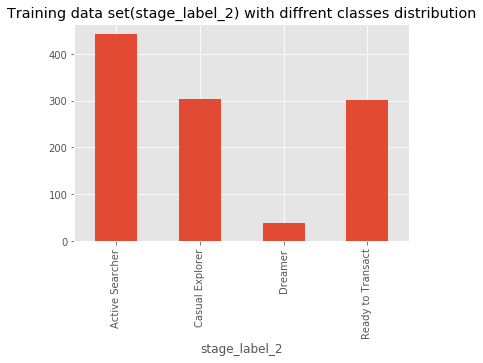

In [53]:
# Training data set user segment distribution : enough data on each class
df_q2_label_dist = pd.read_csv('csvs/buyer_intent_test_set_q2.csv')
df_q2_label_dist = df_q2_label_dist.groupby(['stage_label_2']).size()
df_q2_label_dist.plot.bar(title = 'Training data set(stage_label_2) with diffrent classes distribution')

In [12]:
(best_candidate_2, best_candidate_name_2, best_candidate_performance_2 ) = sm_helper.find_optimal_model(session = sm_helper.session, 
                                                                                                  bucket=sm_helper.bucket, 
                                                                                                  prefix=sm_helper.prefix, 
                                                                                                  train_file_name = 'csvs/buyer_intent_tr_val_set_q2.csv', 
                                                                                                  target_value = 'stage_label_2', 
                                                                                                  opt_metric = 'F1macro', 
                                                                                                  problem_type = 'MulticlassClassification',
                                                                                                  max_candidate = 300, max_runtime = 7200,
                                                                                                  job_suffix ='label2')

file csvs/buyer_intent_tr_val_set_q2.csv uploaded to :s3://datascience-workspace-dev/buyer-intent/ml-sagemaker/autml-buyer-intent/train/buyer_intent_tr_val_set_q2.csv 
Train data uploaded to: s3://datascience-workspace-dev/buyer-intent/ml-sagemaker/autml-buyer-intent/train/buyer_intent_tr_val_set_q2.csv
Start AutoML for Job Name: automl-bi-label2-27-03-50-33
InProgress - Starting
InProgress - Starting
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - ModelTuning
InProgress - ModelTuning
InProgress - ModelTuning
InProgress - ModelTuning
InProgress - ModelTuning
InProgress - ModelTuning
InProgress - ModelTuning
InProgress - ModelTuning
InProgress - ModelTuning
InProgress - ModelTuning
InProgress - ModelTuning
InProgress - ModelTuning
InProgress - ModelTuning
InProgress - ModelTuning
InProgress - ModelTuning
InProg

In [13]:
test_data_s3_path_q2 = sm_helper.load_test_data_on_s3('csvs/buyer_intent_test_set_q2.csv','stage_label_2')

Test data uploaded to: s3://datascience-workspace-dev/buyer-intent/ml-sagemaker/autml-buyer-intent/test/no_trg_buyer_intent_test_set_q2.csv


In [14]:
timestamp_suffix = strftime('%d-%H-%M-%S', gmtime()) 
sm_helper. inference_model(sm = sm_helper.sm, role = sm_helper.role, model_name = 'bi-stage-label2-' + timestamp_suffix, 
                       candidate_container = best_candidate_2['InferenceContainers'], 
                       transform_job_name = 'bi-stage-label2-transform-' + timestamp_suffix, 
                       input_data_on_s3 = test_data_s3_path_q2, 
                       output_bucket = sm_helper.bucket  , 
                       output_prefix =sm_helper.prefix, 
                       instance_type ='ml.m5.xlarge', instance_count = 1)

Model ARN corresponding to the candidate is : arn:aws:sagemaker:us-west-2:289154003759:model/bi-stage-label2-27-05-56-41
InProgress
InProgress
InProgress
Completed


In [15]:
# Load Infered data from S3 to compute precision and recall
sm_helper.load_data_from_s3('s3://{}/{}/inference-results/{}'.format(sm_helper.bucket, sm_helper.prefix,'no_trg_buyer_intent_test_set_q2.csv.out'), 
                  'csvs/infered_label_2.csv')

True

In [16]:
(cm_2, precision_2, recall_2) = sm_helper.compute_precision_recall('csvs/buyer_intent_test_set_q2.csv', 'csvs/infered_label_2.csv', 'stage_label_2' )

In [17]:
print('-----------------------------------------')
print('Confusion Matrix for Second labeling ::')
print(cm_2)
print('Precision ::')
print(precision_2)
print('Recall ::')
print(recall_2)
print('-----------------------------------------')

-----------------------------------------
Confusion Matrix for Second labeling ::
[[ 20   6   9   3]
 [  0 237  50  17]
 [  0  64 362  17]
 [  0  25  59 218]]
Precision ::
[1.         0.71385542 0.75416667 0.85490196]
Recall ::
[0.52631579 0.77960526 0.81715576 0.7218543 ]
-----------------------------------------


## STAGE_LABEL_3

#### STEP 1 : Find Optimal model for third label
#### STEP 2 : Load test data on s3 for inferencing
#### STEP 3 : Find and Run Optimal model to get Inferenced predicted data and load to s3
#### STEP 4 : Compute precision/recall for labels labels = ["Dreamer", "Casual Explorer", "Active Searcher", "Ready to Transact"]
----

In [25]:
#Clean up the prevoius location used by last automl for loading data again
sm_helper.s3_clean_up(bucket = sm_helper.bucket, prefix = sm_helper.param_dict['dev']['train_prefix'])
sm_helper.s3_clean_up(bucket = sm_helper.bucket, prefix=sm_helper.param_dict['dev']['test_prefix'])

True

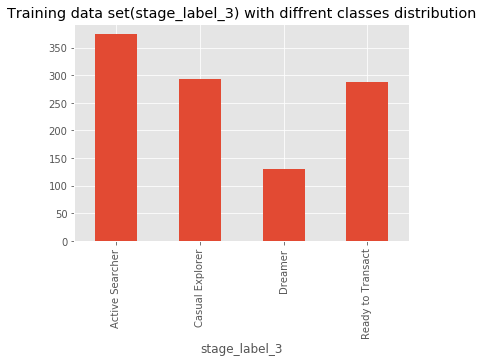

In [52]:
# Training data set user segment distribution : enough data on each class
df_q3_label_dist = pd.read_csv('csvs/buyer_intent_test_set_q3.csv')
df_q3_label_dist = df_q3_label_dist.groupby(['stage_label_3']).size()
df_q3_label_dist.plot.bar(title = 'Training data set(stage_label_3) with diffrent classes distribution')

In [26]:
(best_candidate_3, best_candidate_name_3, best_candidate_performance_3 ) = sm_helper.find_optimal_model(session = sm_helper.session, 
                                                                                                  bucket=sm_helper.bucket, 
                                                                                                  prefix=sm_helper.prefix, 
                                                                                                  train_file_name = 'csvs/buyer_intent_tr_val_set_q3.csv', 
                                                                                                  target_value = 'stage_label_3', 
                                                                                                  opt_metric = 'F1macro', 
                                                                                                  problem_type = 'MulticlassClassification',
                                                                                                  max_candidate = 300, max_runtime = 7200,
                                                                                                  job_suffix ='label3') 

file csvs/buyer_intent_tr_val_set_q3.csv uploaded to :s3://datascience-workspace-dev/buyer-intent/ml-sagemaker/autml-buyer-intent/train/buyer_intent_tr_val_set_q3.csv 
Train data uploaded to: s3://datascience-workspace-dev/buyer-intent/ml-sagemaker/autml-buyer-intent/train/buyer_intent_tr_val_set_q3.csv
Start AutoML for Job Name: automl-bi-label3-27-15-20-57
InProgress - Starting
InProgress - Starting
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - ModelTuning
InProgress - ModelTuning
InProgress - ModelTuning
InProgress - ModelTuning
InProgress - ModelTuning
InProgress - ModelTuning
InProgress - ModelTuning
InProgress - ModelTuning
InProgress - ModelTuning
InProgress - ModelTuning
InProgress - ModelTuning
InProgress - ModelTuning
InProgress - ModelTuning
Completed - MaxAutoMLJobRuntimeReached
Best Candidate Na

In [27]:
test_data_s3_path_q3 = sm_helper.load_test_data_on_s3('csvs/buyer_intent_test_set_q3.csv','stage_label_3')

Test data uploaded to: s3://datascience-workspace-dev/buyer-intent/ml-sagemaker/autml-buyer-intent/test/no_trg_buyer_intent_test_set_q3.csv


In [28]:
timestamp_suffix = strftime('%d-%H-%M-%S', gmtime()) 
sm_helper. inference_model(sm = sm_helper.sm, role = sm_helper.role, model_name = 'bi-stage-label3-' + timestamp_suffix, 
                       candidate_container = best_candidate_3['InferenceContainers'], 
                       transform_job_name = 'bi-stage-label3-transform-' + timestamp_suffix, 
                       input_data_on_s3 = test_data_s3_path_q3, 
                       output_bucket = sm_helper.bucket  , 
                       output_prefix =sm_helper.prefix, 
                       instance_type ='ml.m5.xlarge', instance_count = 1)

Model ARN corresponding to the candidate is : arn:aws:sagemaker:us-west-2:289154003759:model/bi-stage-label3-27-16-27-02
InProgress
InProgress
InProgress
Completed


In [29]:
# Load Infered data from S3 to compute precision and recall
sm_helper.load_data_from_s3('s3://{}/{}/inference-results/{}'.format(sm_helper.bucket,sm_helper.prefix,'no_trg_buyer_intent_test_set_q3.csv.out'), 
                  'csvs/infered_label_3.csv')

True

In [30]:
(cm_3, precision_3, recall_3) = sm_helper.compute_precision_recall('csvs/buyer_intent_test_set_q3.csv', 'csvs/infered_label_3.csv', 'stage_label_3' )

In [31]:
print('-----------------------------------------')
print('Confusion Matrix for Third labeling ::')
print(cm_3)
print('Precision ::')
print(precision_3)
print('Recall ::')
print(recall_3)
print('-----------------------------------------')

-----------------------------------------
Confusion Matrix for Third labeling ::
[[ 82  14  22  12]
 [  4 234  37  19]
 [  3  32 302  38]
 [  1  34  30 223]]
Precision ::
[0.91111111 0.74522293 0.77237852 0.76369863]
Recall ::
[0.63076923 0.79591837 0.80533333 0.77430556]
-----------------------------------------


# Summary
-----------------------------------------
|Label   | Min Precision   | Min Recall  |
|:-:|:-:|:-:|
| **stage_label_1**  |**0.83594864**   |**0.75**   |
| stage_label_2  |0.71385542  |0.52631579  |
| stage_label_3  |0.74522293  |0.63076923   |


**Best Model** : XGboost with :

|Parameter|Value|
|:-:|:-:|
|alpha|0.00024323154907073826|
|colsample_bytree|0.7897946760436036|
|eta|0.3959767109864848|
|gamma|0.02471796689079823|
|lambda|6.229569315092911e-05|
|max_depth|15|
|min_child_weight|2.5049003218066525e-06|
|num_class|4|
|num_round|171|
|subsample|0.8509744839970474|

**Conclusion :** 
*Stage_label_1 works better than the other labeling systems (~ **20%** works better that other two classes)*

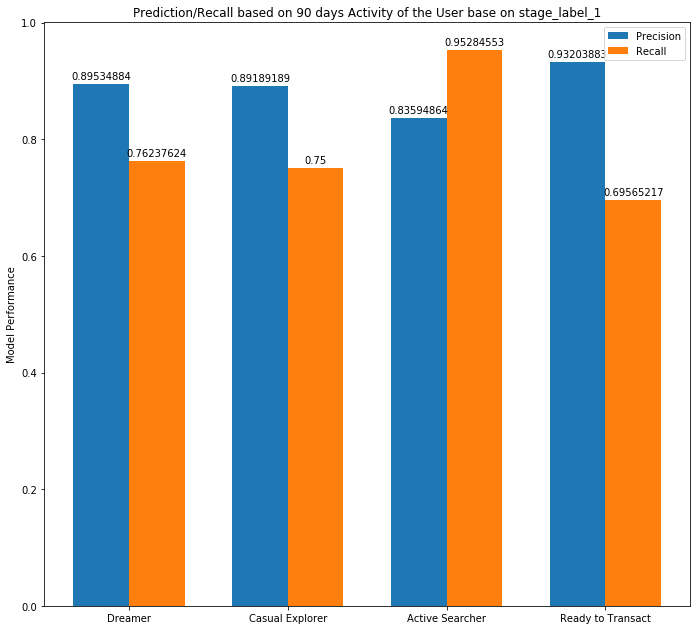

In [4]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

labels = ['Dreamer', 'Casual Explorer', 'Active Searcher', 'Ready to Transact']
pre = [0.89534884, 0.89189189, 0.83594864, 0.93203883]
rec = [0.76237624, 0.75,       0.95284553, 0.69565217]

x = np.arange(len(labels))  # the label locations
#x = labels  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x-width/2, pre, width, label='Precision')
rects2 = ax.bar(x+width/2, rec, width, label='Recall')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Model Performance')
ax.set_title('Prediction/Recall based on 90 days Activity of the User base on stage_label_1')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
fig.set_size_inches(14, 10)

#plt.savefig('pre_recall_90.png')
plt.show()